# Song Classification

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12, 8)

import gc
import os
import ast
import sys
import configparser
import glob
import librosa
import librosa.display
from scipy.stats import mode

from keras.models import Sequential
from keras.models import Model
from keras.layers import Input, LSTM
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Activation
from keras.layers.merge import concatenate
from keras.layers.convolutional import Conv1D
from keras.layers.pooling import MaxPooling1D
from keras.layers.pooling import GlobalMaxPooling1D
from keras.layers.pooling import GlobalAveragePooling1D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU

import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import keras
from keras import backend as K

Using TensorFlow backend.


In [2]:
from pathlib import Path

HOME_PATH = Path.home()
MODELS_PATH = HOME_PATH / 'models'
DATA_PATH = HOME_PATH / 'data'

assert MODELS_PATH.is_dir()
assert DATA_PATH.is_dir()

In [3]:
download = False

In [4]:
if download:
    !kaggle datasets download -d andradaolteanu/gtzan-dataset-music-genre-classification

In [5]:
GTZAN_PATH = DATA_PATH / 'gtzan-music-genres'
DATASET_PATH = GTZAN_PATH / 'genres_original'

In [179]:
genre_folder = DATASET_PATH / 'rock'
# np.random.seed(0)
# song = np.random.choice(os.listdir(genre_folder), 1)[0]
song = 'rock.00032.wav'
signal, sr = librosa.load(genre_folder / song)
melspec = librosa.feature.melspectrogram(signal, sr=sr)

print(song, signal.shape[0] / sr, signal.shape[0] / 512, melspec.shape)

song = 'rock.00044.wav'
signal, sr = librosa.load(genre_folder / song)
melspec = librosa.feature.melspectrogram(signal, sr=sr)

print(song, signal.shape[0] / sr, signal.shape[0] / 512, melspec.shape)

1280 * 512 / sr

rock.00032.wav 30.400907029478457 1309.2578125 (128, 1310)
rock.00044.wav 30.013333333333332 1292.56640625 (128, 1293)


29.72154195011338

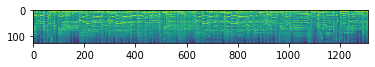

In [157]:
plt.imshow(librosa.power_to_db(melspec, ref=np.max))

rock.00032.wav (128, 1310)


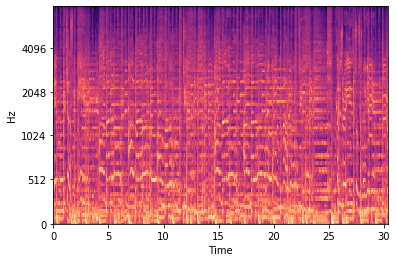

In [154]:
librosa.display.specshow(
    librosa.power_to_db(melspec, ref=np.max),
    y_axis='mel',
    fmax=8000,
    x_axis='time'
)

In [6]:
def load_songs(song_folder):
    song_specs = []
    idx_to_genre = []
    genre_to_idx = {}
    genres = []
    print('Loading data from %s' % song_folder)
    for genre in os.listdir(song_folder):
        genre_to_idx[genre] = len(genre_to_idx)
        idx_to_genre.append(genre)
        genre_folder = os.path.join(song_folder, genre)
        num_songs = 0
#         print('Loading %s songs...' % genre)
        for song in os.listdir(genre_folder):
            if Path(song).suffix in ['.wav']:
                try:
                    signal, sr = librosa.load(os.path.join(genre_folder, song))
                    melspec = librosa.feature.melspectrogram(signal, sr=sr).T[:1280,]
                    song_specs.append(melspec)
                    genres.append(genre_to_idx[genre])
                    num_songs += 1
                except Exception as e:
                    pass
        print('Loaded %d %s songs.' % (num_songs, genre))
        
    print(
        'Finished loading %d songs from %d genres.'
        % (len(song_specs), len(set(genres)))
    )
    
    return song_specs, genres, genre_to_idx, idx_to_genre

In [21]:
%%time
song_specs, genres, genre_to_idx, idx_to_genre = load_songs(DATASET_PATH)

Loading data from /home/mrduhart/data/gtzan-music-genres/genres_original
Loaded 100 blues songs.
Loaded 100 classical songs.
Loaded 100 country songs.
Loaded 100 disco songs.
Loaded 100 hiphop songs.
Loaded 99 jazz songs.
Loaded 100 metal songs.
Loaded 100 pop songs.
Loaded 100 reggae songs.
Loaded 100 rock songs.
Finished loading 999 songs from 10 genres.
CPU times: user 6min 16s, sys: 6min 48s, total: 13min 5s
Wall time: 2min


In [22]:
song_specs[0].shape

(1280, 128)

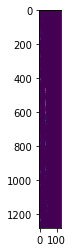

In [60]:
song_idx = 101

plt.imshow(song_specs[song_idx])

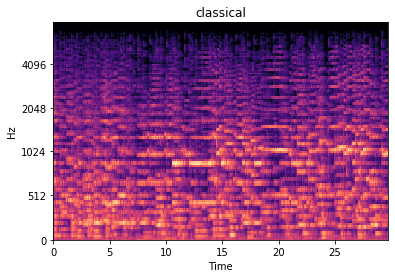

In [61]:
librosa.display.specshow(
    librosa.power_to_db(song_specs[song_idx].T, ref=np.max),
    y_axis='mel',
    fmax=8000,
    x_axis='time'
)

plt.title(idx_to_genre[genres[song_idx]]);

(1280, 3200)


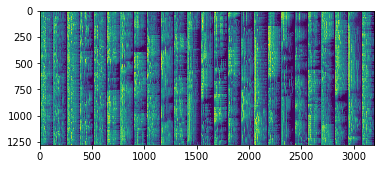

In [53]:
def show_spectrogram(show_genre):
    show_genre = genre_to_idx[show_genre]
    specs = []
    for spec, genre in zip(song_specs, genres):
        if show_genre == genre:
            specs.append(librosa.power_to_db(spec.T, ref=np.max).T)
            if len(specs) == 25:
                break
    if not specs:
        return 'not found!'
    x = np.concatenate(specs, axis=1)
#     x = (x - x.min()) / (x.max() - x.min())
    print(x.shape)
    plt.imshow(x)

    
show_spectrogram('classical')

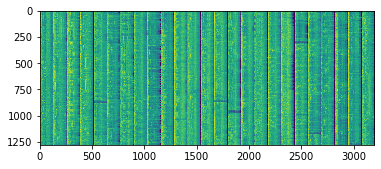

In [52]:
show_spectrogram('metal')

## Training the network

In [26]:
def lstm_model(input_shape):
    inputs = Input(shape=input_shape, name='input')
    lstm_1 = LSTM(units=128, return_sequences=False)(inputs)
    
    dense2 = Dense(10, activation='softmax')(lstm_1)

    model = Model(inputs=[inputs], outputs=[dense2])
    sgd = keras.optimizers.SGD(lr=0.0003, momentum=0.9, decay=1e-5, nesterov=True)
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=sgd,
                  metrics=['accuracy'])
    return model

def cnn_model(input_shape):
    inputs = Input(input_shape)
    x = inputs
    levels = 64
    
    for level in range(3):
        x = Conv1D(levels, 3, activation='relu')(x)
        x = BatchNormalization()(x)
        x = MaxPooling1D(pool_size=2, strides=2)(x)
        levels *= 2 # Duplicates the number of filters in each layer
    
    # Global Layers
    x = GlobalMaxPooling1D()(x)

    for fc in range(2):
        x = Dense(256, activation='relu')(x)
        x = Dropout(0.5)(x)

    labels = Dense(10, activation='softmax')(x)

    model = Model(inputs=[inputs], outputs=[labels])
    sgd = keras.optimizers.SGD(lr=0.0003, momentum=0.9, decay=1e-5, nesterov=True)
    model.compile(loss='categorical_crossentropy',
                  optimizer=sgd,
                  metrics=['accuracy'])
    return model

model = cnn_model((128, 128))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 128, 128)          0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 126, 64)           24640     
_________________________________________________________________
batch_normalization_4 (Batch (None, 126, 64)           256       
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 63, 64)            0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 61, 128)           24704     
_________________________________________________________________
batch_normalization_5 (Batch (None, 61, 128)           512       
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 30, 128)           0         
__________

In [27]:
def split_10(x, y):
    """Splits the spectrogram each 10 windows (with 128 mel bands)
    and repeats the genre label for all the reshaped windows
    """
    s = x.shape
    s = (s[0] * 10, s[1] // 10, s[2])
    return x.reshape(s), np.repeat(y, 10, axis=0)

Prepare dataset:

In [57]:
%%time

genres_one_hot = keras.utils.to_categorical(genres, num_classes=len(genre_to_idx))

x_train, x_test, y_train, y_test = train_test_split(
    np.array(song_specs), np.array(genres_one_hot), 
    test_size=0.1, stratify=genres)

print(len(song_specs), song_specs[0].shape)
print(x_train.shape, y_train.shape)

999 (1280, 128)
(899, 1280, 128) (899, 10)
CPU times: user 516 ms, sys: 2.3 s, total: 2.81 s
Wall time: 2.82 s


In [58]:
%%time

x_test, y_test = split_10(x_test, y_test)
x_train, y_train = split_10(x_train, y_train)

x_train.shape, y_train.shape

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 190 µs


((8990, 128, 128), (8990, 10))

In [28]:
earlystop = keras.callbacks.EarlyStopping(monitor='val_loss',
      min_delta=0,
      patience=3,
      verbose=0,
      mode='auto')

In [29]:
%%time

# Fit the model
history = model.fit(x_train, y_train,
      batch_size=128,
      epochs=100,
      verbose=1,
      validation_data=(x_test, y_test),
      callbacks = [earlystop])

Train on 8990 samples, validate on 1000 samples
Epoch 1/100
8990/8990 [==============================] - 15s 2ms/step - loss: 3.5954 - acc: 0.1159 - val_loss: 2.1918 - val_acc: 0.1890
Epoch 2/100
8990/8990 [==============================] - 7s 834us/step - loss: 2.4566 - acc: 0.1672 - val_loss: 2.0099 - val_acc: 0.2610
Epoch 3/100
8990/8990 [==============================] - 8s 845us/step - loss: 2.2032 - acc: 0.2137 - val_loss: 1.9459 - val_acc: 0.3060
Epoch 4/100
8990/8990 [==============================] - 7s 796us/step - loss: 2.1317 - acc: 0.2316 - val_loss: 1.9158 - val_acc: 0.3180
Epoch 5/100
8990/8990 [==============================] - 7s 803us/step - loss: 2.0634 - acc: 0.2585 - val_loss: 1.9106 - val_acc: 0.3220
Epoch 6/100
8990/8990 [==============================] - 7s 788us/step - loss: 2.0305 - acc: 0.2713 - val_loss: 1.8570 - val_acc: 0.3280
Epoch 7/100
8990/8990 [==============================] - 7s 806us/step - loss: 1.9864 - acc: 0.2918 - val_loss: 1.8341 - val_acc: 0

In [30]:
model.save('zoo/15/song_classify.h5')

In [31]:
def unsplit(values):
    chunks = np.split(values, 100)
    return np.array([np.argmax(chunk) % 10 for chunk in chunks])

pred_values = model.predict(x_test)
predictions = unsplit(pred_values)
truth = unsplit(y_test)
accuracy_score(predictions, truth)

0.55

In [32]:
cm = confusion_matrix(np.argmax(pred_values, axis=1), np.argmax(y_test, axis=1))
print(cm)

[[43  0 22  6  6  4  3  0  2  1]
 [ 0 77  1  0  0 37  1  0  0  4]
 [12  1 23  4  0  1  9  1  0  3]
 [ 1  0  2 61  5  0  1  4  4  8]
 [ 6  0  0 12 53  0  3 34 15  4]
 [ 9 16 28  0  0 38  5  0  0 15]
 [11  3  7 10  6  2 67  1  0 36]
 [ 3  0  3  1 22  0  1 59  8  3]
 [11  0  2  4  5 12  9  1 69  2]
 [ 4  3 12  2  3  6  1  0  2 24]]


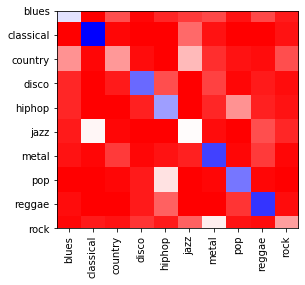

In [33]:
plt.imshow(cm.T, interpolation='nearest', cmap='bwr_r')
plt.xticks(np.arange(0, len(idx_to_genre)), idx_to_genre, rotation='vertical')
plt.yticks(np.arange(0, len(idx_to_genre)), idx_to_genre)

plt.show()

In [34]:
m1 = cnn_melspect_1D_org((128, 128))
m2 = cnn_melspect_1D((128, 128))
ac1 = 0.61 * 5
ac2 = 0
for i in range(5):
    history = m1.fit(x_train, y_train,
      batch_size=128,
      epochs=100,
      verbose=0,
      validation_data=(x_test, y_test),
      callbacks = [earlystop])
    ac1 += history.history['val_acc'][-1]
    history = m2.fit(x_train, y_train,
      batch_size=128,
      epochs=100,
      verbose=0,
      validation_data=(x_test, y_test),
      callbacks = [earlystop])
    ac2 += history.history['val_acc'][-1]

print(ac1 / 5, ac2 / 5)

NameError: name 'cnn_melspect_1D_org' is not defined